In [1]:
# TODO
# p-value / statistic
# finalize plot


import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from plotting import mimic_r_boxplot

from data_loading import (load_y2h_isoform_data, 
    load_m1h_activation_data, 
    load_ppi_partner_categories, 
    load_valid_isoform_clones,
    load_human_tf_db,
    load_y1h_pdi_data,
    load_ref_vs_alt_isoforms_table)
from data_loading.isoform_pairwise_metrics import _add_PPI_columns

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
y2h = load_y2h_isoform_data()
m1h = load_m1h_activation_data()
cats = load_ppi_partner_categories()

In [4]:
cof = pd.read_csv('../data/external/AnimalTFDB3_Homo_sapiens_TF_cofactors.txt',
                 sep='\t')
if cof['Symbol'].duplicated().any():
    raise UserWarning('unexpected duplicates')

In [5]:
cof.tail()

,Species,Symbol,Ensembl,Family,Entrez ID
1020,Homo_sapiens,TAF9,ENSG00000273841,TATA-box,6880
1021,Homo_sapiens,MLLT6,ENSG00000275023,Others,4302
1022,Homo_sapiens,AATF,ENSG00000275700,Others,26574
1023,Homo_sapiens,PCGF2,ENSG00000277258,PCGF,7703
1024,Homo_sapiens,PAGR1,ENSG00000280789,Others,79447


In [6]:
y2h.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result
0,ATF2|1/6|12H04,ATF2,ATF2,True
3,ATF2|1/6|12H04,ATF2,FOSL2,NaN
4,ATF2|1/6|12H04,ATF2,JDP2,True
12,ATF2|2/6|09E05,ATF2,ATF2,True
15,ATF2|2/6|09E05,ATF2,FOSL2,NaN


In [7]:
# number of cofactors
# number of PPI with cofactors
# split by family
print(cof.shape[0], 'cofactors')
print(y2h.loc[y2h['db_gene_symbol'].isin(cof['Symbol']), 'db_gene_symbol'].nunique(),
      ' of which we have PPIs for')
print(y2h['db_gene_symbol'].isin(cof['Symbol']).sum(),
      ' cofactor PPIs')
cof_with_ppi = set(y2h.loc[y2h['db_gene_symbol'].isin(cof['Symbol']), 'db_gene_symbol'].unique())
print(cof.loc[cof['Symbol'].isin(cof_with_ppi), 'Family'].value_counts())

1025 cofactors
63  of which we have PPIs for
465  cofactor PPIs
Others                      29
Other_CRF                    4
LIM                          3
Cyclin                       2
Vestigial like               2
Ring finger protein          2
Histone deacetylase          2
WD                           1
MAGE                         1
Lysine acetyltransferase     1
TEF                          1
NFKB associated              1
HNRNP                        1
Chromobox                    1
Tripartite motif             1
SSX                          1
DPF                          1
INO80 complex                1
FHL                          1
SMYD                         1
TATA-box                     1
PHF                          1
Mediator complex             1
Bromodomain                  1
WW                           1
RNA helicase                 1
Name: Family, dtype: int64


In [8]:
df = pd.read_excel('../data/external/Geiger-et-al_MCP_2012_Supplementary-Table-2.xlsx',
                   skiprows=1)
hek_avrg = df[['iBAQ HEK293_1', 'iBAQ HEK293_2', 'iBAQ HEK293_3']].mean(axis=1)
print((hek_avrg > 0).sum(), 'proteins expressed in HEK293 proteome')
hek_expressed_genes = set(df.loc[(hek_avrg > 0) & df['Gene Names'].notnull(),
       'Gene Names'].str.split(';').explode().values)
all_partners = set(y2h['db_gene_symbol'].unique())
print('of {} PPI partners, {} are expressed in HEK293 cells'.format(len(all_partners), 
      len(all_partners.intersection(hek_expressed_genes))))


8543 proteins expressed in HEK293 proteome
of 500 PPI partners, 252 are expressed in HEK293 cells


## pie charts

In [9]:
len(cats)

1114

In [10]:
len(cats.partner.unique())

987

In [11]:
cats.category.value_counts()

TF                     239
cofactor               165
signaling              141
other                  101
metabolism              81
cytoskeleton            77
protein turnover        60
RNA processing          59
vesicle transport       47
cell cycle              36
DNA repair              28
translation             20
cell-cell signaling     19
membrane protein        14
RNA turnover             9
nuclear transport        6
DNA polymerase           6
DNA replication          5
protein traffiking       1
Name: category, dtype: int64

In [12]:
y2h_nonan = y2h[~pd.isnull(y2h["Y2H_result"])]
len(y2h_nonan.db_gene_symbol.unique())

500

In [13]:
ggi = y2h_nonan[["ad_gene_symbol", "db_gene_symbol"]].drop_duplicates()
ggi

,ad_gene_symbol,db_gene_symbol
0,ATF2,ATF2
4,ATF2,JDP2
39,ATF2,FOSL2
73,ATF2,MAPK9
122,CREB5,EFEMP2
...,...,...
10218,TCF12,HEXIM2
10246,DDIT3,ZBTB25
10247,DDIT3,ZC3H14
10271,TCF12,EPHB6


In [14]:
# limiting df to those that are in the y2h iso data
cats_y2h = cats[cats["partner"].isin(ggi["db_gene_symbol"])]
len(cats_y2h)

506

In [15]:
cats_dupe = cats_y2h.groupby("partner")["category"].agg("count").reset_index()
cats_dupe[cats_dupe["category"] > 1].head()

,partner,category
9,ARHGEF5,2
24,BARD1,3
48,CCNK,2
51,CDCA7L,2
53,CDK3,3


In [16]:
# keeping partners that are assigned more than 1 category for now...
cats_y2h[cats_y2h["partner"] == "BARD1"]

,partner,category,cofactor_type
30,BARD1,cofactor,both
31,BARD1,RNA processing,NaN
32,BARD1,DNA repair,NaN


In [17]:
def categorize_PPI_partner(row):
    if row['category'] == "TF":
        return 'TF'
    elif row['category'] == "cofactor":
        return 'cofactor'
    elif row['category'] == "signaling":
        return 'signaling'
    else:
        return 'other'
    
cats_y2h["partner_category"] = cats_y2h.apply(categorize_PPI_partner, axis=1)
cats_y2h.partner_category.value_counts()

<ipython-input-17-3718f9df0eeb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_y2h["partner_category"] = cats_y2h.apply(categorize_PPI_partner, axis=1)


other        235
TF           128
cofactor      78
signaling     65
Name: partner_category, dtype: int64

In [18]:
cats['category'].value_counts()

TF                     239
cofactor               165
signaling              141
other                  101
metabolism              81
cytoskeleton            77
protein turnover        60
RNA processing          59
vesicle transport       47
cell cycle              36
DNA repair              28
translation             20
cell-cell signaling     19
membrane protein        14
RNA turnover             9
nuclear transport        6
DNA polymerase           6
DNA replication          5
protein traffiking       1
Name: category, dtype: int64

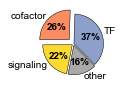

In [19]:
ys = np.array([len(cats[cats["category"] == "TF"]), len(cats[cats["category"] == "cofactor"]),
               len(cats[cats["category"] == "signaling"]),
              len(cats[cats["category"] == "other"])])
labels = ["TF", "cofactor", "signaling", "other"]
colors = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[1], sns.color_palette("Set2")[5], "darkgray"]

fig, ax = plt.subplots(figsize=(1.6, 1.6), subplot_kw=dict(aspect="equal"))
ws, ls, ns = ax.pie(ys, colors=colors, labels=labels, autopct='%1.0f%%', startangle=-45, 
                    explode=(0.02, 0.2, 0.05, 0.05))

for n, w in zip(ns, ws):
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
    n.set_fontweight("bold")

fig.savefig("../figures/PPIs-gene-level-manual-categories_simplified.pdf", dpi="figure", bbox_inches="tight")

In [20]:
cofactor_partners = set(cats.loc[cats['category'] == 'cofactor', 'partner'].unique())
coactivator_partners = set(cats.loc[cats['cofactor_type'] == 'coactivator', 'partner'].unique())
corepressor_partners = set(cats.loc[cats['cofactor_type'] == 'corepressor', 'partner'].unique())
both_partners = set(cats.loc[cats['cofactor_type'] == 'both', 'partner'].unique())
signaling_partners = set(cats.loc[cats['category'] == 'signaling', 'partner'].unique())
cofactor_animal_db = set(cof['Symbol'].unique())
gene_symbols = set(load_human_tf_db()['HGNC symbol'].values)

In [21]:
def categorize_cofactors(row):
    if row["partner_category"] == "cofactor":
        if row["partner"] in both_partners:
            return "both"
        elif row["partner"] in coactivator_partners:
            return "coactivator"
        elif row["partner"] in corepressor_partners:
            return "corepressor"
        else:
            return "unknown"
    else:
        return "NA"
    
cats_y2h["cofactor_type"] = cats_y2h.apply(categorize_cofactors, axis=1)
cats_y2h.cofactor_type.value_counts()

<ipython-input-21-6ae1b1c02e80>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_y2h["cofactor_type"] = cats_y2h.apply(categorize_cofactors, axis=1)


NA             428
corepressor     29
coactivator     28
both            12
unknown          9
Name: cofactor_type, dtype: int64

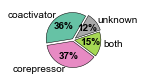

In [22]:
cofacs = cats_y2h[cats_y2h["partner_category"] == "cofactor"]

ys = np.array([len(cofacs[cofacs["cofactor_type"] == "coactivator"]), 
               len(cofacs[cofacs["cofactor_type"] == "corepressor"]),
               len(cofacs[cofacs["cofactor_type"] == "both"]),
               len(cofacs[cofacs["cofactor_type"] == "unknown"])])
labels = ["coactivator", "corepressor", "both", "unknown"]
colors = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[3], sns.color_palette("Set2")[4], "darkgray"]

fig, ax = plt.subplots(figsize=(1.9, 1.9), subplot_kw=dict(aspect="equal"))
ws, ls, ns = ax.pie(ys, colors=colors, labels=labels, autopct='%1.0f%%', startangle=60, 
                    explode=(0.05, 0.05, 0.05, 0.1))

for n, w in zip(ns, ws):
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
    n.set_fontweight("bold")

fig.savefig("../figures/PPIs-gene-level-manual-categories_cofactors.pdf", dpi="figure", bbox_inches="tight")

In [23]:
pairs = load_ref_vs_alt_isoforms_table()


def add_restricted_ppi_columns(pairs, rows, label):
      pairs_cf = pairs[['clone_acc_ref', 'clone_acc_alt']].copy()
      _add_PPI_columns(df=pairs_cf, y2h=y2h.loc[rows, :])
      return pd.merge(pairs, 
                    pairs_cf, 
                    how='left', 
                  on=['clone_acc_ref', 'clone_acc_alt'],
                    suffixes=('', '_' + label))

pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(cofactor_partners),
                           label='cofactors'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(cofactor_animal_db),
                           label='cofactors_animal_db'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(coactivator_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='coactivators_HEK'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(coactivator_partners) &
                                 ~y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='coactivators_not_HEK'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=~y2h['db_gene_symbol'].isin(cofactor_partners),
                           label='not_cofactors'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(coactivator_partners),
                           label='coactivators'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(corepressor_partners),
                           label='corepressors'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(corepressor_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='corepressors_HEK'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(gene_symbols),
                           label='tfs'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(signaling_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='signaling_HEK'
)

In [24]:
def bar_activation_vs_ppi(x, y, pairs=pairs, x_label=None, y_label=None, color=None):
    """
    TODO:
        - calculate p-value properly
            - this requires permuting in some smart way
            - one question is whether the genes are the number of independent data points or the isoforms are
            - I think the answer is the isoforms are
    
    """
    df = pairs.copy()
    if x_label is None:
        x_label = x
    if y_label is None:
        y_label = y
    if color is None:
        color = sns.color_palette("Set2")[1]
    fig, ax = plt.subplots(1, 1, figsize=(3.2, 2.25))

    def bin_delta_ppi(delta_ppi):
        if pd.isnull(delta_ppi):
            return np.nan
        if delta_ppi < 0:
            return 'loss'
        elif delta_ppi > 0:
            return 'gain'
        elif delta_ppi == 0:
            return 'equal'
        else:
            raise ValueError(delta_ppi)


    df[x + '_binned'] = df[x].apply(bin_delta_ppi)
    sns.stripplot(data=df,
                  x=x + '_binned',
                  y=y,
                  order=['loss', 'equal', 'gain'],
                  alpha=0.75,
                  color=color,
                  linewidth=1,
                  edgecolor="black",
                  ax=ax)
    if False:
        sns.pointplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['loss', 'equal', 'gain'],
                    alpha=0.5,
                    color='black',
                    ax=ax)
    if True:
        sns.boxplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['loss', 'equal', 'gain'],
                    fliersize=0,
                    color=color,
                    ax=ax)
        mimic_r_boxplot(ax)
    else:
        sns.violinplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['loss', 'equal', 'gain'],
                    color='lightgrey',
                    ax=ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    with_data = (df[x].notnull() & df[y].notnull())
    n_pair = with_data.sum()
    n_iso = len(set(df.loc[with_data, ['clone_acc_ref', 'clone_acc_alt']].values.flatten()))
    n_gene = df.loc[with_data, 'gene_symbol'].nunique()
    scc, p_scc = stats.spearmanr(df.loc[df[x].notnull() & df[y].notnull(), x].values,
                    df.loc[df[x].notnull() & df[y].notnull(), y].values)
    ax.text(s=f'{n_pair:d} pairs\n{n_iso:d} isoforms\n{n_gene:d} genes\nSpearman r = {scc:.2f}\np = {p_scc:.2f}',
            x=1.03,
            y=0.95,
            ha='left',
            va='top',
            transform=ax.transAxes)
    #ax.set_ylim(-4, 4) # NOTE cuts outlier TODO add broken axis
    ax.axhline(y=0, color='black', linestyle="dashed", linewidth=1)
    for pos in ['top', 'bottom', 'right']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    fig.savefig(f'../figures/{x}-vs-{y}_scatter.pdf',
                bbox_inches='tight')

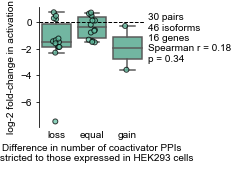

In [25]:
bar_activation_vs_ppi(
    pairs=pairs.loc[pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_coactivators_HEK',
    y='activation_fold_change_log2',
    x_label='Difference in number of coactivator PPIs\nrestricted to those expressed in HEK293 cells',
    y_label='log-2 fold-change in activation',
    color=sns.color_palette("Set2")[0])

In [26]:
# TEST what is the outlier on the left
(pairs.loc[(pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True)
           & (pairs['PPI_delta_n_coactivators_HEK'].notnull()), 
              :]
           .sort_values('activation_fold_change_log2',
                        ascending=False))[["gene_symbol", "clone_acc_ref", "clone_acc_alt",
                                           "PPI_delta_n_coactivators_HEK", "activation_fold_change_log2"]]

,gene_symbol,clone_acc_ref,clone_acc_alt,PPI_delta_n_coactivators_HEK,activation_fold_change_log2
359,TCF4,TCF4|1/9|07E01,TCF4|7/9|07G03,-3.0,0.721583
356,TCF4,TCF4|1/9|07E01,TCF4|4/9|07G02,0.0,0.699990
355,TCF4,TCF4|1/9|07E01,TCF4|3/9|07C04,0.0,0.621134
54,NFE2L2,NFE2L2|1/3|12H08,NFE2L2|2/3|01F05,0.0,0.541562
115,HSF2,HSF2|1/2|12B08,HSF2|2/2|09A10,0.0,0.464849
360,TCF4,TCF4|1/9|07E01,TCF4|8/9|07A05,-3.0,0.455881
261,TFCP2,TFCP2|1/3|03E08,TFCP2|3/3|03F10,-2.0,0.276447
119,NFYA,NFYA|1/3|07H01,NFYA|2/3|07G01,-1.0,0.196268
354,TCF4,TCF4|1/9|07E01,TCF4|2/9|07E03,0.0,0.102610
19,LHX9,LHX9|1/3|06C10,LHX9|3/3|07A01,0.0,0.102355


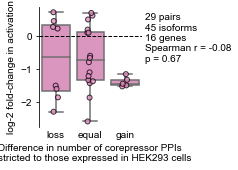

In [27]:
bar_activation_vs_ppi(
    pairs=pairs.loc[pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_corepressors_HEK',
    y='activation_fold_change_log2',
    x_label='Difference in number of corepressor PPIs\nrestricted to those expressed in HEK293 cells',
    y_label='log-2 fold-change in activation',
    color=sns.color_palette("Set2")[3])

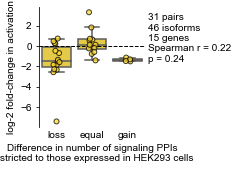

In [28]:
bar_activation_vs_ppi(
    pairs=pairs.loc[pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_signaling_HEK',
    y='activation_fold_change_log2',
    x_label='Difference in number of signaling PPIs\nrestricted to those expressed in HEK293 cells',
    y_label='log-2 fold-change in activation',
    color=sns.color_palette("Set2")[5])

In [29]:
# TEST what is the outlier on the left
(pairs.loc[(pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True)
           & (pairs['PPI_delta_n_signaling_HEK'].notnull()), 
              :]
           .sort_values('activation_fold_change_log2',
                        ascending=True))[["gene_symbol", "clone_acc_ref", "clone_acc_alt",
                                           "PPI_delta_n_coactivators_HEK", "activation_fold_change_log2"]].head(30)

,gene_symbol,clone_acc_ref,clone_acc_alt,PPI_delta_n_coactivators_HEK,activation_fold_change_log2
127,E2F3,E2F3|2/4|10A08,E2F3|3/4|10B08,-1.0,-7.433645
290,TCF12,TCF12|1/3|07D07,TCF12|3/3|07B07,NaN,-2.587343
142,CREB5,CREB5|1/3|08E11,CREB5|2/3|08A12,NaN,-2.342060
362,FOSB,FOSB|1/3|05D03,FOSB|2/3|05E04,-1.0,-2.293175
120,NFYA,NFYA|1/3|07H01,NFYA|3/3|11D05,-2.0,-1.864474
342,MEOX1,MEOX1|1/3|08C05,MEOX1|2/3|08G04,-3.0,-1.857521
358,TCF4,TCF4|1/9|07E01,TCF4|6/9|07H03,-4.0,-1.598357
226,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|3/9|10B06,0.0,-1.525376
343,MEOX1,MEOX1|1/3|08C05,MEOX1|3/3|08G03,-3.0,-1.501980
228,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|5/9|10H05,0.0,-1.493713


In [30]:
pairs[pairs["gene_symbol"] == "PBX1"][["gene_symbol", "clone_acc_ref", "clone_acc_alt",
                                           "PPI_delta_n_signaling_HEK", "activation_fold_change_log2"]]

,gene_symbol,clone_acc_ref,clone_acc_alt,PPI_delta_n_signaling_HEK,activation_fold_change_log2
20,PBX1,PBX1|1/2|02A05,PBX1|2/2|02C05,NaN,-1.099522


In [31]:
cats[cats["partner"] == "PIN1"]

,partner,category,cofactor_type
917,PIN1,TF,NaN
